# Imports + Cache Loader + Cycle Lists

In [1]:
import os
import numpy as np
import pandas as pd
import requests
import pyreadstat

# Cache directory
CACHE_DIR = "nhanes_cache"
os.makedirs(CACHE_DIR, exist_ok=True)

# ---------------------------------------
# Helper: Load NHANES XPT with caching
# ---------------------------------------
def load_nhanes_xpt(filename: str, year: str):
    local_path = os.path.join(CACHE_DIR, f"{year}_{filename}")

    if os.path.exists(local_path):
        df, meta = pyreadstat.read_xport(local_path)
        return df

    url = f"https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/{year}/DataFiles/{filename}"
    r = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})

    if r.status_code == 404:
        print(f"Missing: {filename} for {year}")
        return None

    with open(local_path, "wb") as f:
        f.write(r.content)

    df, meta = pyreadstat.read_xport(local_path)
    return df


# ---------------------------------------
# Cycle file dictionaries (2011–2018)
# ---------------------------------------
def cycle(year, suffix):
    return {
        "DEMO":   f"DEMO_{suffix}.xpt",
        "HDL":    f"HDL_{suffix}.xpt",
        "TCHOL":  f"TCHOL_{suffix}.xpt",
        "TRIGLY": f"TRIGLY_{suffix}.xpt",
        "GLU":    f"GLU_{suffix}.xpt",
        "INS":    f"INS_{suffix}.xpt" if suffix != "G" else "GLU_G.xpt",
        "DPQ":    f"DPQ_{suffix}.xpt",
        "SLQ":    f"SLQ_{suffix}.xpt",
        "DR1TOT": f"DR1TOT_{suffix}.xpt",
        "PAQ":    f"PAQ_{suffix}.xpt",
        "BPX":    f"BPX_{suffix}.xpt",
        "BIOPRO": f"BIOPRO_{suffix}.xpt",      # ALT/AST in some cycles
        "ALB_CR": f"ALB_CR_{suffix}.xpt",
        "BMX":    f"BMX_{suffix}.xpt",          # BMI/waist
        "CBC":    f"CBC_{suffix}.xpt",
    }

all_cycles = {
    "2011": cycle("2011", "G"),
    "2013": cycle("2013", "H"),
    "2015": cycle("2015", "I"),
    "2017": cycle("2017", "J"),
}


# Merge NHANES Cycles

In [2]:
def load_cycle(files: dict, year: str):
    dfs = []
    for name, fname in files.items():
        d = load_nhanes_xpt(fname, year)
        if d is not None:
            dfs.append(d)

    if not dfs:
        return None

    merged = dfs[0]
    for d in dfs[1:]:
        merged = merged.merge(d, on="SEQN", how="outer")

    merged["CYCLE"] = year
    return merged


df_list = []
for yr, files in all_cycles.items():
    print(f"Loading cycle {yr} ...")
    out = load_cycle(files, yr)
    if out is not None:
        df_list.append(out)

df_all = pd.concat(df_list, ignore_index=True)
print("Merged NHANES shape:", df_all.shape)


Loading cycle 2011 ...
Loading cycle 2013 ...
Loading cycle 2015 ...
Loading cycle 2017 ...
Merged NHANES shape: (39156, 495)


# Harmonization Functions

In [3]:
# ----------------------------------
# Demographics
# ----------------------------------
def harmonize_demographics(df):
    out = df.copy()
    out["age"] = out.get("RIDAGEYR", np.nan)
    out["sex"] = out["RIAGENDR"].map({1: "Male", 2: "Female"}) if "RIAGENDR" in out else np.nan
    out["pir"] = out.get("INDFMPIR", np.nan)
    out["race_ethnicity"] = out.get("RIDRETH3", np.nan)
    return out


# ----------------------------------
# Blood Pressure
# ----------------------------------
def harmonize_bp(df):
    out = df.copy()
    sbp_cols = [c for c in out if c.startswith("BPXSY")]
    dbp_cols = [c for c in out if c.startswith("BPXDI")]

    out["sbp"] = out[sbp_cols].mean(axis=1) if sbp_cols else np.nan
    out["dbp"] = out[dbp_cols].mean(axis=1) if dbp_cols else np.nan
    out["pulse_pressure"] = out["sbp"] - out["dbp"]
    return out


# ----------------------------------
# Lipids
# ----------------------------------
def harmonize_lipids(df):
    out = df.copy()
    out["hdl"] = out.get("LBDHDD", np.nan)
    out["tc"]  = out.get("LBXTC", np.nan)
    out["tg"]  = out.get("LBXTR", np.nan)

    if "LBXTC" in out and "LBDHDD" in out:
        out["ldl"] = out["LBXTC"] - out["LBDHDD"] - (out["LBXTR"] / 5)
    else:
        out["ldl"] = np.nan

    out["apob_est"] = 0.65 * out["tc"] - 0.59 * out["hdl"]
    return out


# ----------------------------------
# Renal
# ----------------------------------
def harmonize_renal(df):
    out = df.copy()
    out["creat_mg_dl"] = out.get("LBXSCR", np.nan)
    out["egfr"] = 175 * (out["creat_mg_dl"] ** -1.154) * 1.018
    out["acr"] = out.get("URXUM", np.nan) / out.get("URXCRS", np.nan)
    return out


# ----------------------------------
# Metabolic
# ----------------------------------
def harmonize_metabolic(df):
    out = df.copy()
    out["glucose"] = out.get("LBXGLU", np.nan)
    out["insulin"] = out.get("LBXINS", np.nan)
    out["homa_ir"] = (out["glucose"] * out["insulin"]) / 405
    return out


# ----------------------------------
# Sleep
# ----------------------------------
def harmonize_sleep(df):
    out = df.copy()
    out["sleep_hours"] = out.get("SLD010H", np.nan)
    out["sleep_trouble"] = out.get("SLQ050", np.nan)
    return out


# ----------------------------------
# PHQ-9
# ----------------------------------
def harmonize_phq(df):
    out = df.copy()
    phq_cols = [c for c in out.columns if c.startswith("DPQ0")]
    if phq_cols:
        out["phq9"] = out[phq_cols].sum(axis=1)
    else:
        out["phq9"] = np.nan
    return out


# ----------------------------------
# PA days + index
# ----------------------------------
def harmonize_physical_activity_days(df):
    out = df.copy()
    out["pa_vigorous_days"] = out.get("PAQ650", np.nan)
    out["pa_moderate_days"] = out.get("PAQ665", np.nan)
    out["pa_walk_days"]     = out.get("PAQ670", np.nan)

    out["pa_index"] = (
        2*out["pa_vigorous_days"]
        + out["pa_moderate_days"]
        + 0.5*out["pa_walk_days"]
    )
    return out


# ----------------------------------
# Diet (food groups)
# ----------------------------------
def harmonize_diet(df):
    out = df.copy()
    diet_map = {
        "whole_grains": "DR1TWHL",
        "refined_grains": "DR1TGR",
        "nuts_seeds": "DR1TNS",
        "legumes": "DR1TLEG",
        "low_fat_dairy": "DR1TDLF",
        "fish": "DR1TFISH",
        "red_meat": "DR1TREDM",
        "processed_meat": "DR1TPRM",
        "other_fruit": "DR1TFRT",
        "citrus_melons_berries": "DR1TCITM",
        "dark_green_veg": "DR1TVEG1",
        "other_veg": "DR1TVEG2",
        "ssb": "DR1TSSB",
        "fried_foods": "DR1TFF",
    }
    for new, old in diet_map.items():
        out[new] = out.get(old, np.nan)
    return out


# ----------------------------------
# BMI + waist
# ----------------------------------
def harmonize_additional(df):
    out = df.copy()
    out["bmi"]   = out.get("BMXBMI", np.nan)
    out["waist"] = out.get("BMXWAIST", np.nan)
    return out


# ----------------------------------
# ALT / AST + CBC
# ----------------------------------
def harmonize_liver_and_cbc(df):
    out = df.copy()

    # ALT
    for col in ["LBXALT","LBDALT","LBDALTSI","LBXSAT","LBXSATSI","LBXSAPSI"]:
        if col in out:
            out["alt"] = out[col]
            break
    else:
        out["alt"] = np.nan

    # AST
    for col in ["LBXAST","LBDAST","LBDASSI","LBXSAS","LBXSASSI"]:
        if col in out:
            out["ast"] = out[col]
            break
    else:
        out["ast"] = np.nan

    # Hemoglobin
    out["hemoglobin"] = out.get("LBXHGB", np.nan)

    # WBC
    out["wbc"] = out.get("LBXWBCSI", out.get("LBXWBC", np.nan))

    # Platelets
    out["platelets"] = out.get("LBXPLTSI", out.get("LBXPLT", np.nan))

    return out


# Master Harmonization Pipeline

In [4]:
def prepare_nhanes(df):
    return (
        df
        .pipe(harmonize_demographics)
        .pipe(harmonize_bp)
        .pipe(harmonize_lipids)
        .pipe(harmonize_renal)
        .pipe(harmonize_metabolic)
        .pipe(harmonize_sleep)
        .pipe(harmonize_phq)
        .pipe(harmonize_physical_activity_days)
        .pipe(harmonize_diet)
        .pipe(harmonize_liver_and_cbc)
        .pipe(harmonize_additional)
    )

df_h = prepare_nhanes(df_all)
print(df_h.shape)

df_h[["bmi","waist","alt","ast","wbc","hemoglobin","platelets"]].notna().mean()


(39156, 541)


bmi           0.878997
waist         0.837139
alt           0.630325
ast           0.629737
wbc           0.820870
hemoglobin    0.820870
platelets     0.820845
dtype: float64

# Variable-level GGM (Biovista backbone)

In [6]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import GraphicalLasso

# -------------------------------------------------------
# 1. Define system → variable map for variable-level GGM
# -------------------------------------------------------
physio_systems_ggm = {
    "Demographics": ["age", "pir"],

    "Lipids": ["hdl", "tc", "tg", "ldl", "apob_est"],

    "Metabolic": [
        "glucose", "insulin", "homa_ir",
        "bmi", "waist"
    ],

    "Blood_Pressure": ["sbp", "dbp", "pulse_pressure"],

    "Renal": ["creat_mg_dl", "egfr", "acr"],

    "Liver": ["alt", "ast"],

    "Inflammation": ["wbc"],

    "Hematologic": ["hemoglobin", "platelets"],

    "Sleep": ["sleep_hours", "sleep_trouble"],

    "Mental_Health": ["phq9"],

    "Physical_Activity": [
        "pa_vigorous_days", "pa_moderate_days",
        "pa_walk_days", "pa_index"
    ],

    "Diet": [
        "whole_grains", "refined_grains", "nuts_seeds", "legumes",
        "low_fat_dairy", "fish", "red_meat", "processed_meat",
        "other_fruit", "citrus_melons_berries", "dark_green_veg",
        "other_veg", "ssb", "fried_foods"
    ],
}

# -------------------------------------------------------
# 2. Flatten & filter by missingness ≥ 40%
# -------------------------------------------------------
all_vars = sum(physio_systems_ggm.values(), [])
all_vars = [v for v in all_vars if v in df_h.columns]

nonmissing_frac = df_h[all_vars].notna().mean()
vars_use = nonmissing_frac[nonmissing_frac >= 0.40].index.tolist()

print("Variables used in variable-level GGM:", len(vars_use))
print(vars_use)

# -------------------------------------------------------
# 3. Impute + standardize
# -------------------------------------------------------
X = df_h[vars_use].to_numpy(float)

imputer = KNNImputer(n_neighbors=5)
X_imp = imputer.fit_transform(X)

scaler = StandardScaler()
X_std = scaler.fit_transform(X_imp)

# -------------------------------------------------------
# 4. Fit Graphical Lasso
# -------------------------------------------------------
ggm_model = GraphicalLasso(alpha=0.15, max_iter=200)
ggm_model.fit(X_std)

precision = ggm_model.precision_.copy()

# Partial correlations
diag = np.sqrt(np.diag(precision))
outer = np.outer(diag, diag)
partial_corr = -precision / outer
np.fill_diagonal(partial_corr, 0.0)

# -------------------------------------------------------
# 5. Build NetworkX graph
# -------------------------------------------------------
G_var = nx.Graph()

# Map variable → system
var_to_system = {}
for system, var_list in physio_systems_ggm.items():
    for v in var_list:
        if v in vars_use:
            var_to_system[v] = system

# Add nodes
for v in vars_use:
    G_var.add_node(v, system=var_to_system.get(v, "Other"))

# Add edges with small threshold
edge_threshold = 0.10
for i, vi in enumerate(vars_use):
    for j in range(i + 1, len(vars_use)):
        vj = vars_use[j]
        w = partial_corr[i, j]
        if abs(w) >= edge_threshold:
            G_var.add_edge(vi, vj, weight=w)

print(f"Variable-level GGM: {G_var.number_of_nodes()} nodes, {G_var.number_of_edges()} edges")

# -------------------------------------------------------
# 6. Layout for consistent plotting
# -------------------------------------------------------
pos_var = nx.spring_layout(G_var, seed=1, k=0.35)


Variables used in variable-level GGM: 22
['age', 'pir', 'hdl', 'tc', 'apob_est', 'bmi', 'waist', 'sbp', 'dbp', 'pulse_pressure', 'creat_mg_dl', 'egfr', 'alt', 'ast', 'wbc', 'hemoglobin', 'platelets', 'sleep_trouble', 'phq9', 'pa_vigorous_days', 'pa_moderate_days', 'fried_foods']
Variable-level GGM: 22 nodes, 17 edges


# Create a simulated “interesting” patient

In [9]:
# -------------------------------------------------------
# 1. Population mean & SD for these variables
# -------------------------------------------------------
df_desc = df_h[vars_use].describe()
mu = df_desc.loc["mean"]
sd = df_desc.loc["std"].replace(0, np.nan)   # guard against divide-by-zero

# Start at mean
patient_vals = mu.copy()

# -------------------------------------------------------
# 2. Make an "interesting" patient (abnormal in several systems)
#    (You can tweak these z-values to taste.)
# -------------------------------------------------------
z_overrides = {
    # Lipids / metabolic
    "apob_est": +2.0,
    "hdl": -1.5,
    "tg": +2.0,
    "glucose": +2.0,
    "insulin": +2.0,
    "homa_ir": +2.5,
    "bmi": +2.0,
    "waist": +2.0,

    # BP
    "sbp": +1.5,
    "dbp": +1.0,

    # Renal
    "egfr": -1.0,
    "acr": +1.5,

    # Liver
    "alt": +2.0,
    "ast": +1.5,

    # Inflammation / hematology
    "wbc": +1.5,
    "hemoglobin": -1.0,
    "platelets": +1.0,

    # Sleep / mental health
    "sleep_hours": -1.5,
    "sleep_trouble": +1.5,
    "phq9": +2.0,

    # Physical activity
    "pa_index": -2.0,

    # Diet (if present)
    "whole_grains": -1.0,
    "red_meat": +1.5,
    "ssb": +2.0,

    # Demographics
    "age": +1.0,
    "pir": -1.0,
}

for var, z in z_overrides.items():
    if var in patient_vals.index and pd.notna(sd[var]):
        patient_vals[var] = mu[var] + z * sd[var]

# -------------------------------------------------------
# 3. Variable-level z-scores for this patient
# -------------------------------------------------------
z_patient = (patient_vals - mu) / sd
z_patient = z_patient.fillna(0.0)

z_patient.head()


age         1.0
pir        -1.0
hdl        -1.5
tc          0.0
apob_est    2.0
dtype: float64

# Plot Biovista-style variable-level network

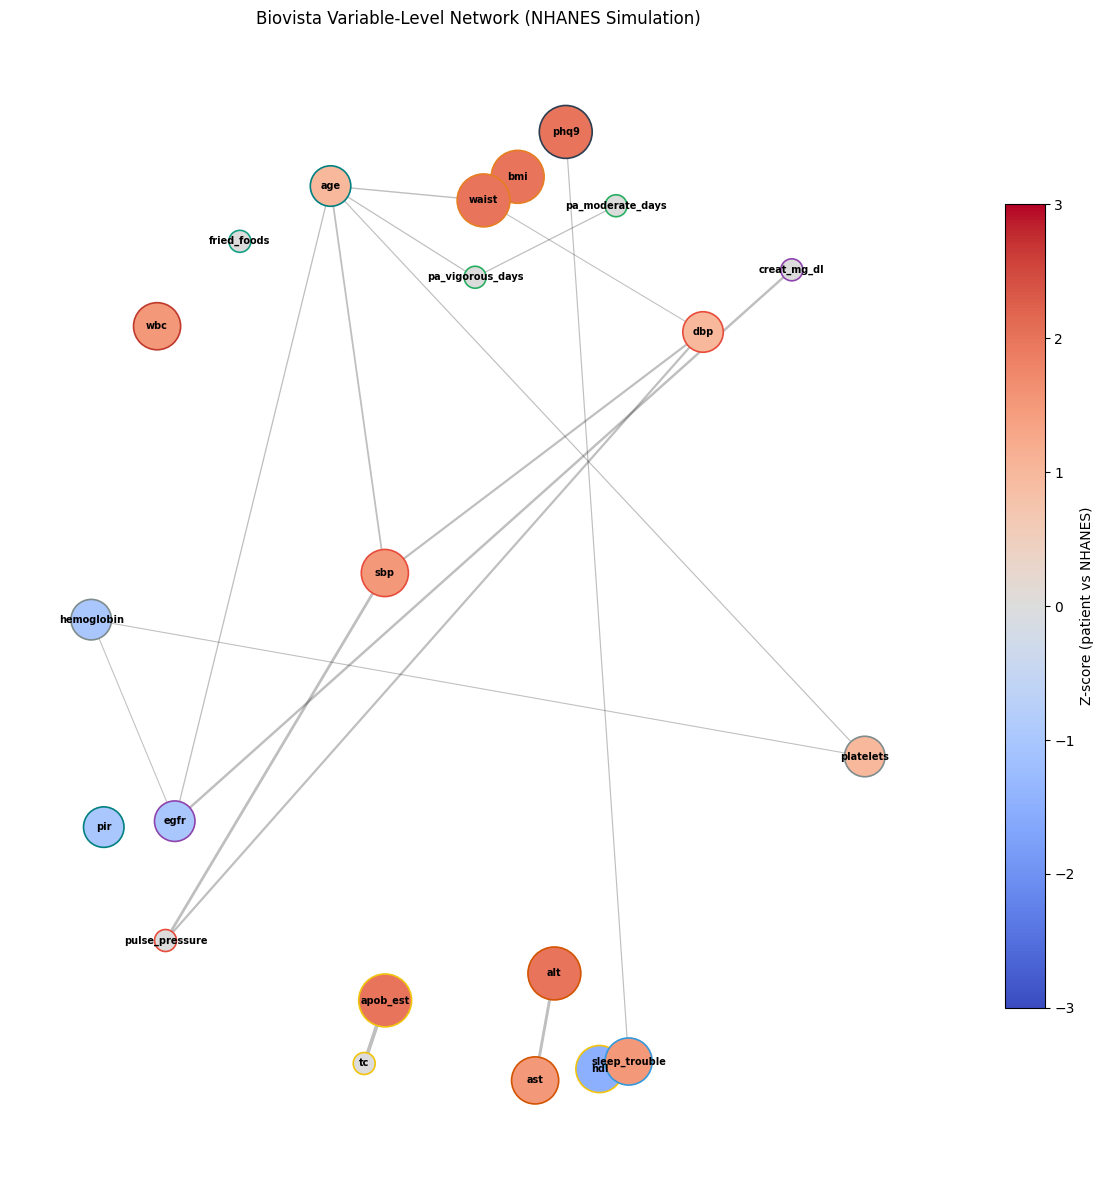

Saved: biovista_variable_patient_network.png


In [10]:
# -------------------------------------------------------
# Pretty plotting function (variable-level Biovista)
# -------------------------------------------------------
system_color_map = {
    "Demographics": "#008080",
    "Lipids": "#f1c40f",
    "Metabolic": "#e67e22",
    "Blood_Pressure": "#e74c3c",
    "Renal": "#8e44ad",
    "Liver": "#d35400",
    "Inflammation": "#c0392b",
    "Hematologic": "#7f8c8d",
    "Sleep": "#3498db",
    "Mental_Health": "#2c3e50",
    "Physical_Activity": "#27ae60",
    "Diet": "#16a085",
    "Other": "#7f8c8d",
}

def plot_biovista_patient_network(
    G,
    z_scores,
    var_to_system,
    pos,
    title="Biovista Variable-Level Network (NHANES Simulation)",
    out_file="biovista_variable_patient_network.png"
):
    # Attach z-scores + system labels
    for n in G.nodes():
        G.nodes[n]["z"] = float(z_scores.get(n, 0.0))
        G.nodes[n]["system"] = var_to_system.get(n, "Other")

    z_vals = np.array([G.nodes[n]["z"] for n in G.nodes()])
    z_clipped = np.clip(z_vals, -3, +3)

    # Color by z-score
    cmap = plt.cm.coolwarm
    node_colors = cmap((z_clipped + 3) / 6)

    # Size by |z|
    node_sizes = 250 + 600 * np.abs(z_clipped)

    # Edge widths by |weight|
    edge_widths = [
        0.4 + 3.0 * abs(d.get("weight", 0.05))
        for (_, _, d) in G.edges(data=True)
    ]

    # Node outlines by system
    node_edgecolors = [
        system_color_map.get(G.nodes[n]["system"], "#7f8c8d")
        for n in G.nodes()
    ]

    fig, ax = plt.subplots(figsize=(12, 12))

    nx.draw_networkx_edges(
        G, pos,
        width=edge_widths,
        alpha=0.25,
        ax=ax
    )

    nx.draw_networkx_nodes(
        G, pos,
        node_color=node_colors,
        node_size=node_sizes,
        edgecolors=node_edgecolors,
        linewidths=1.2,
        ax=ax
    )

    nx.draw_networkx_labels(
        G, pos,
        font_size=7,
        font_weight="bold",
        ax=ax
    )

    # Colorbar for z-score
    sm = plt.cm.ScalarMappable(
        cmap=cmap, norm=plt.Normalize(vmin=-3, vmax=3)
    )
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, shrink=0.7)
    cbar.set_label("Z-score (patient vs NHANES)")

    ax.set_title(title)
    ax.axis("off")
    plt.tight_layout()
    fig.savefig(out_file, dpi=350, bbox_inches="tight")
    plt.show()

    return fig, ax

# -------------------------------------------------------
# 8. Generate and save the figure
# -------------------------------------------------------
fig, ax = plot_biovista_patient_network(
    G_var,
    z_patient,
    var_to_system,
    pos_var,
    title="Biovista Variable-Level Network (NHANES Simulation)",
    out_file="biovista_variable_patient_network.png"
)

print("Saved: biovista_variable_patient_network.png")
